In [ ]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by: 

## Reconstruction using Krylov subspace solver LSQR: semi-convergence and Tikhonov regularisation without block-functions

In [2]:
import sys
sys.path.append(".")

from LSQR import *
from LSQR_Tikhonov import *

from LSQRLP import *
from LSQRMP import *

from CGLSLP import *
from CGLSMP import *

# CIL core components needed
from cil.io import TIFFStackReader
from cil.processors import Normaliser, TransmissionAbsorptionConverter, Padder, CentreOfRotationCorrector, Slicer
from cil.framework import ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer

# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import CGLS
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, FiniteDifferenceOperator

# CIL example synthetic test image
from cil.utilities.dataexample import SHAPES
from cil.utilities import dataexample
from cil.utilities.jupyter import islicer

# CIL display tools
from cil.utilities.display import show2D, show1D, show_geometry

# CIL FBP
from cil.recon import FBP

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# Third-party imports
import numpy as np    
import scipy
import os
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import re

In [3]:
# Functions to process the outputs:

def mem_prof_process(output):
    mem_prof = output.stdout

    # split text into lines
    blocks = re.split(r"Filename: .+", mem_prof)[1:]
    pattern = r"\s*(\d+)\s+([\d.]*){1}(\s*MiB\s*){1}(-?[\d.]+){1}(\s*MiB\s*){1}(\d+){1}(\s+.*)"
    repNum = None
   
    for idx, block in enumerate(blocks):
        # split the string into lines
        lines = block.split('\n')    
        memusages = []
            
        # iterate over each line/string
        for line in lines:          
            memUsgMatch = re.match(pattern, line)
            funcNmMatch = re.match(r"\s*(\d+)\s*(def (.+)\(.*)", line)
            
            if funcNmMatch:
                funcName = funcNmMatch.group(2)
                method = funcNmMatch.group(3)
                if method == "update":
                    rearr=True
                if repNum is not None:
                    method = f"{method} {repNum}"

            if memUsgMatch:
                memusages.append(float(memUsgMatch.group(2)))

            repMatch = re.match(r"(\w+) (\d+)", line)
            if repMatch:
                repNum = repMatch.group(2)

        blocks[idx] = [method, funcName.strip('\r'), memusages[0], memusages[-1]]
    
    rearrBlocks = list(reversed(blocks[:2]))
    currGroup = []
    for i, item in enumerate(blocks[2:]):
        method = item[0]
    
        repNumMatch = re.match(r'\w+ (\d+)', method)
        if repNumMatch:
            repNum = int(repNumMatch.group(1))
    
            if not currGroup:
                currGroup.append(item)
                
            elif repNum == int(re.search(r'\w+ (\d+)', currGroup[-1][0]).group(1)):
                currGroup.append(item)
            else:
                rearrBlocks.extend(list(reversed(currGroup)))
                currGroup = [item]
            if i == len(blocks[2:])-1:
                rearrBlocks.extend(list(reversed(currGroup)))       
        else:
            rearrBlocks.append(item)

    mp_df = DataFrame(rearrBlocks, columns=['Method', 'Method Call', 'Initial Memory Usage (MiB)', 'Final Memory Usage (MiB)'])
    mp_df['Total Memory Usage (MiB)'] = mp_df['Final Memory Usage (MiB)'] - mp_df['Initial Memory Usage (MiB)']

    return mp_df

def line_prof_process(output):
    line_prof = output.stdout
    df = {'Method': ['init', 'setup'], 'Initial Memory Usage (MiB)': [], 'Final Memory Usage (MiB)': []}
    memory_usage = {'init': [], 'setup': [], 'run': []}
    countrun = 1

    for res in line_prof.splitlines():
        match = re.match(r"(\w+) of (\w+).+ ([0-9]+\.[0-9]+).+", res)
        if match:
            action, method, value = match.groups()
            value = float(value)

            if action == 'Start' and method =='run' and method not in df['Method']:
                df['Method'].append(f"{method} {countrun}")
                countrun += 1

            if method.startswith('run'):
                memory_usage['run'].append(value)
            elif method in memory_usage:
                memory_usage[method].append(value)

    # Populate initial and final memory usage
    df['Initial Memory Usage (MiB)'] = [memory_usage['init'][0], memory_usage['setup'][0]] + memory_usage['run'][::2]
    df['Final Memory Usage (MiB)'] = [memory_usage['init'][1], memory_usage['setup'][1]] + memory_usage['run'][1::2]

    lp_df = DataFrame(df)
    lp_df['Total Memory Usage (MiB)'] = lp_df['Final Memory Usage (MiB)'] - lp_df['Initial Memory Usage (MiB)']
    lp_df

    return lp_df

def split_groups(line_prof_peak):
    pattern = r"(\w+) of (\w+).+ ([0-9]+\.[0-9]+).+"
    groups = {}
    stack = []
    methodrep = None
    
    for line in line_prof_peak.splitlines():
        repmatch = re.match(r"(^\w*) ([0-9]+$)", line)
        if repmatch: # Find repetitions of methods i.e. run/update
            methodrep = (repmatch.group(1), repmatch.group(2))   

        match = re.match(pattern, line) # Find line-by-line outputs
        if match:
            action, method, value = match.groups()
            value = float(value)
            if methodrep:
                method = f"{method} {methodrep[1]}"

            if action == "Start": # Stores new method encounter & adds to top of stack
                groups[method] = []
                stack.append(method)
                groups[method].append(line)
            elif action == "End": # Remove current method from top of stack
                groups[method].append(line)
                stack.pop(-1)

        elif stack: # Put all lines with the method on top of stack
            method = stack[-1]
            groups[method].append(line)
            if line.startswith("Memory Usage Log"): # Add background/peak memory lines to parent & child methods' group
                for parent_method in stack[:-1]: 
                    groups[parent_method].append(line)
            
    return groups

def line_peak_process(output):
    line_prof_peak = output.stdout
    df = {'Method': [], 'Initial Memory Usage (MiB)': [], 'Peak Memory': [], 'Final Memory Usage (MiB)': [], 'Peak Line': []}
    groups = split_groups(line_prof_peak)
    pattern = r"(\w+) of (\w+).+ ([0-9]+\.[0-9]+).+"
    
    for method, block in groups.items():  # iterate over keys [init, start, run1, update1, run2, update2 ...]
        peakline = ""
        awaiting_line = True
        methodpeak = 0
        r = re.compile(pattern) # Get start and end memory usages for current method's block
        start, end = list(filter(r.match, block))
        startmem = float(re.match(pattern, start).group(3))
        endmem = float(re.match(pattern, end).group(3))

        df['Method'].append(method)
        df['Initial Memory Usage (MiB)'].append(startmem)
        df['Final Memory Usage (MiB)'].append(endmem)

        for line in block: # Find peak memory usage in current block 
            peakmatch = re.match(r".+ (\d+\.\d+)\s*MB.*", line)
            if peakmatch:
                currmem = float(peakmatch.group(1))
                if currmem > methodpeak:
                    methodpeak = currmem
                    awaiting_line = True

            codematch = re.match(r".+ \| Memory Usage: (\d+.\d+) MB \| line:(.+)+", line)
            if codematch: # Find the line-by-line output to attribute to the peak usage
                currmem = float(codematch.group(1))
                if currmem > methodpeak:
                    methodpeak = currmem
                    peakline = codematch.group(2).strip()
                    awaiting_line = False 
                elif awaiting_line:  
                    peakline = codematch.group(2).strip()
                    awaiting_line = False

        df['Peak Memory'].append(methodpeak)
        df['Peak Line'].append(peakline)

    df = DataFrame(df)
    df.insert(4, 'Total Memory Usage (MiB)', df['Final Memory Usage (MiB)']-df['Initial Memory Usage (MiB)'])
    df.insert(5, 'Peak Memory Increase (MiB)', df['Peak Memory']-df['Initial Memory Usage (MiB)'])
    
    return df

def plot_mem(df, algNm=""):
    df = df.iloc[::2]
    # Flatten data for sequential plotting
    methods = []
    stages = []
    values = []

    for _, row in df.iterrows():
        methods.extend([row["Method"]] * 3)
        stages.extend(["Initial", "Peak", "Final"])
        values.extend([row["Initial Memory Usage (MiB)"], row["Peak Memory"], row["Final Memory Usage (MiB)"]])

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(values)), values, marker="o", linestyle="-")

    # x-axis method labels
    xticksPos = [i for i in range(len(values))]
    xticksLabels = [f"{method} - {stage}" for method, stage in zip(methods, stages)]

    plt.xticks(xticksPos, xticksLabels, rotation=60, ha="right", fontsize=10)

    # titles & labels
    plt.title(f"{algNm} Memory Usage by Method (Sequential)", fontsize=14)
    plt.xlabel("Methods and Memory Stages", fontsize=12)
    plt.ylabel("Memory (MB)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)

    # highlight transitions between methods
    for i in range(0, len(values), 3):
        plt.axvline(i - 0.5, color="orange", linestyle="--", alpha=0.5)  # divider between methods

    plt.tight_layout()
    plt.show()

### Loading The Sandstone Dataset

In [2]:
dataexample.SANDSTONE.download_data(data_dir='.', prompt=False)

Dataset folder already exists in .


In [3]:
datapath = './sandstone'

filename = "slice_0270_data.mat"
all_data = scipy.io.loadmat(os.path.join(datapath,filename))

In [4]:
sandstone = all_data['X_proj'].astype(np.float32)
sandstone.shape

(2560, 1500)

In [5]:
ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2560))        \
         .set_angles(angles=np.linspace(0,180,1500,endpoint=False)) \
         .set_labels(['horizontal','angle'])
print(ag.dimension_labels)

sandstone = AcquisitionData(sandstone, geometry=ag, deep_copy=False)

(<AcquisitionDimension.HORIZONTAL: 'horizontal'>, <AcquisitionDimension.ANGLE: 'angle'>)


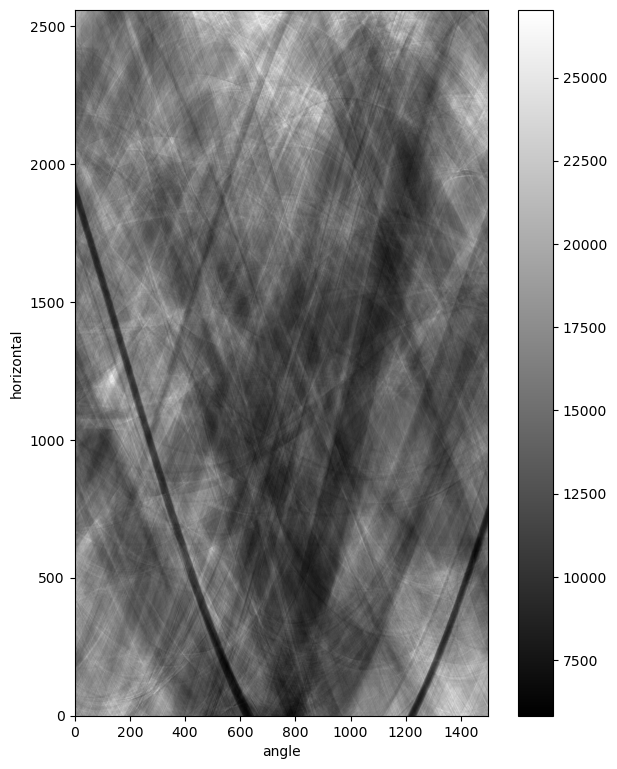

In [6]:
show2D(sandstone)

### Ground Truth - FBP Reconstruction of normalised sandstone

#### Flat and Dark Field Correction:

In [7]:
flats = all_data['X_flat'].astype(np.float32)
flats.shape

darks = all_data['X_dark'].astype(np.float32)
darks.shape

(2560, 30)

In [8]:
sandstone.reorder('astra')

In [9]:
sandstone_norm = Normaliser(flat_field=flats.mean(axis=1),
                   dark_field=darks.mean(axis=1))(sandstone)

sandstone_norm = TransmissionAbsorptionConverter()(sandstone_norm)

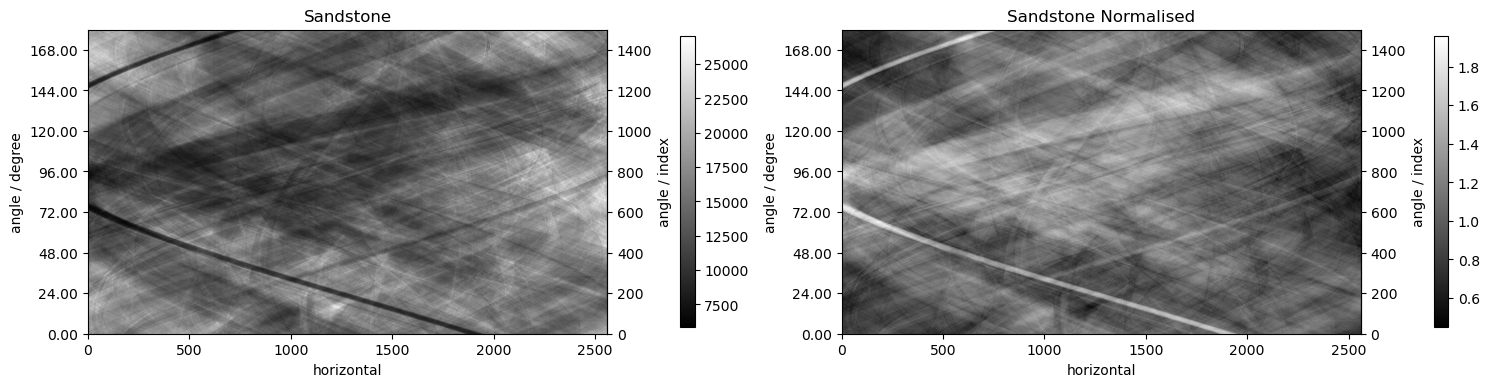

In [10]:
show2D([sandstone, sandstone_norm], title=['Sandstone', 'Sandstone Normalised'])

In [11]:
padsize = 600
sandstone_pad = Padder.edge(pad_width={'horizontal': padsize})(sandstone_norm)

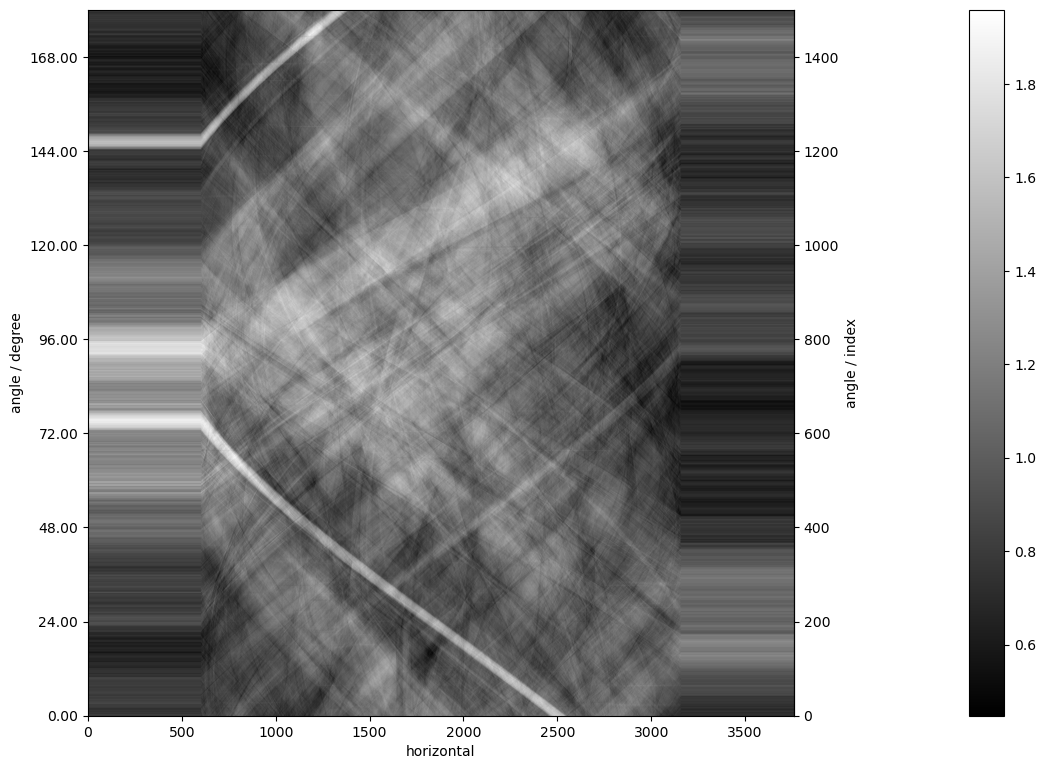

In [12]:
show2D(sandstone_pad)

In [13]:
sandstone_cor = CentreOfRotationCorrector.image_sharpness(backend='astra', search_range=100, tolerance=0.1)(sandstone_pad)
sandstone_cor.geometry.get_centre_of_rotation(distance_units='pixels')

{'offset': (44.48700388605622, 'pixels'), 'angle': (0.0, 'radian')}

In [14]:
ig = sandstone_norm.geometry.get_ImageGeometry()
recon = FBP(sandstone_cor, ig, backend='astra').run()

FBP recon

Input Data:
	angle: 1500
	horizontal: 3760

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



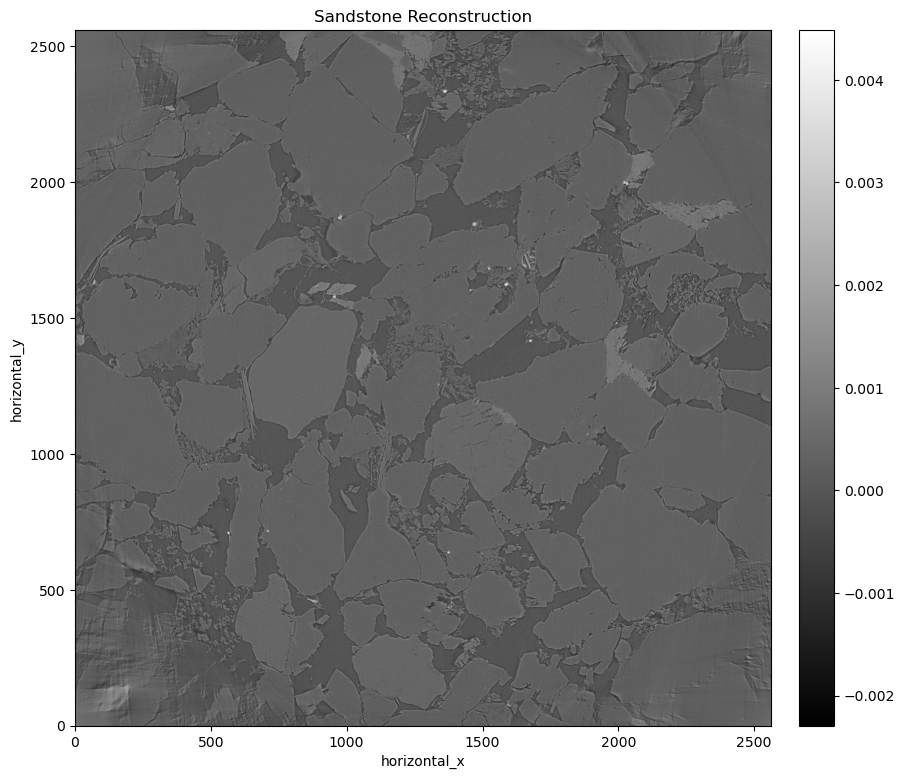

In [15]:
show2D(recon, title='Sandstone Reconstruction')

### Apply Noise:

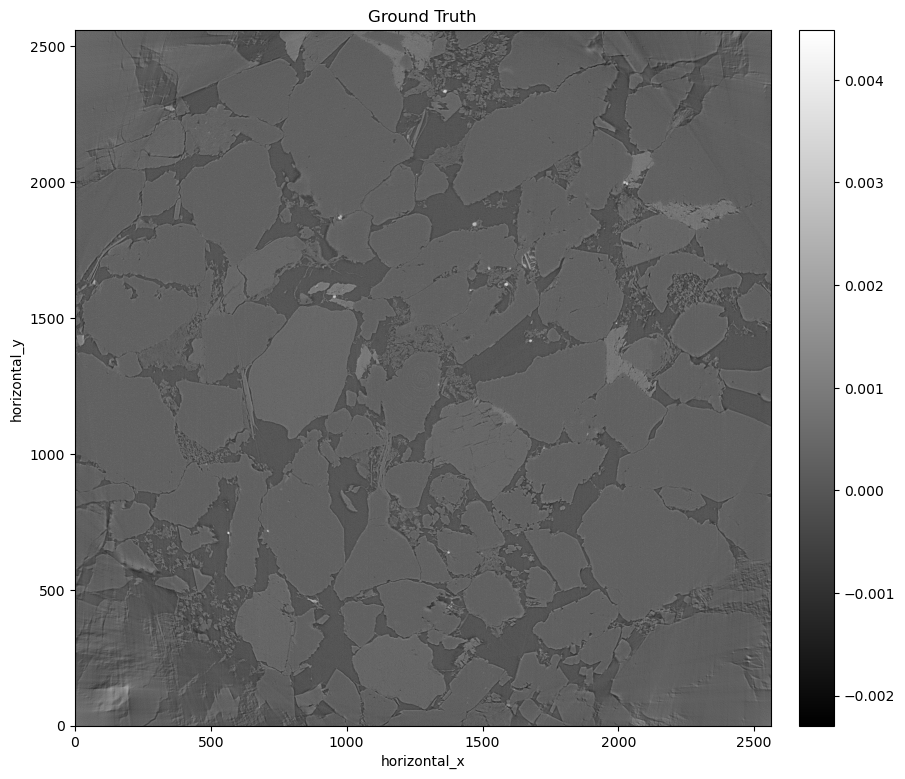

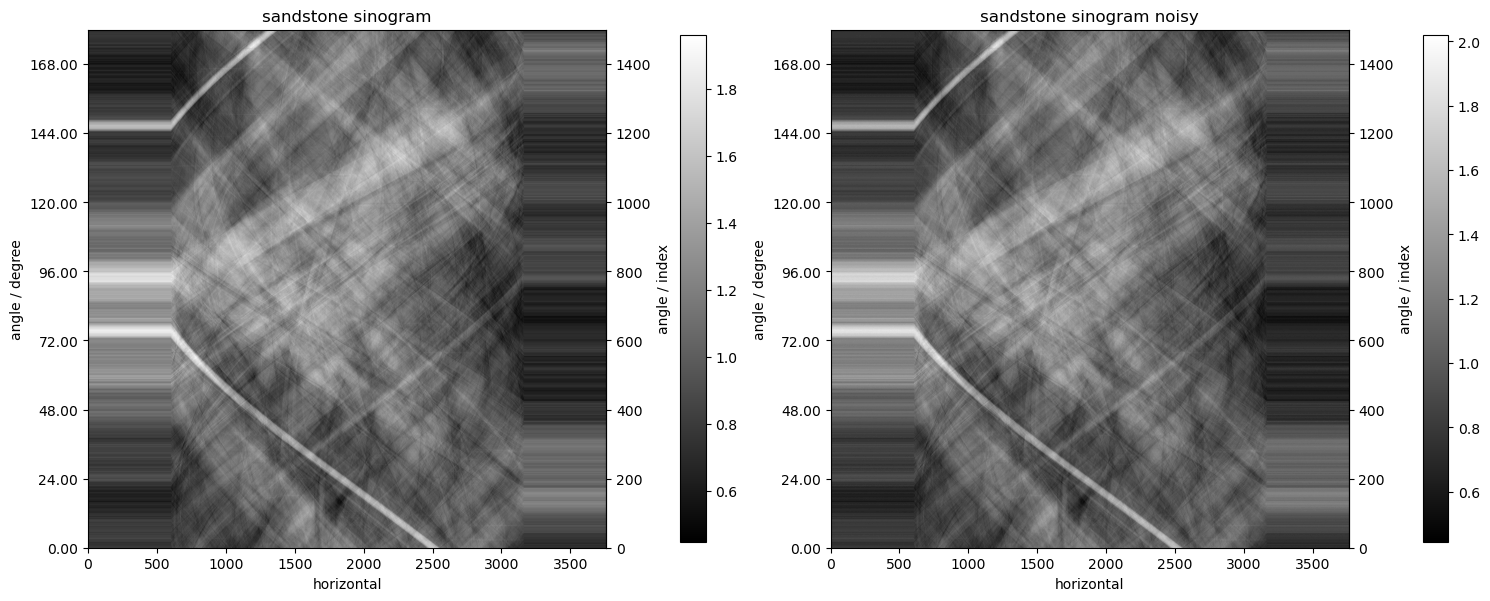

In [16]:
# Incident intensity: lower counts will increase the noise
background_counts = 10000

# Convert the simulated absorption sinogram to transmission values using Lambert-Beer. 
# Use sandstone_cor as mean for Poisson data generation.
# Convert back to absorption sinogram.
counts = background_counts * np.exp(-sandstone_cor.as_array())
noisy_counts = np.random.poisson(counts)
sand_noisy_data = -np.log(noisy_counts/background_counts)

# Create new AcquisitionData object with same geometry as sandstone_cor and fill with noisy data.
sandstone_noisy = sandstone_cor.geometry.allocate()
sandstone_noisy.fill(sand_noisy_data)
show2D(recon, title="Ground Truth")

plots = [sandstone_cor, sandstone_noisy]
titles = ["sandstone sinogram", "sandstone sinogram noisy"]
show2D(plots, titles)

### CGLS and LSQR without regularisation

Before describing Tikhonov regularisation, we recall the problem solved by LSQR:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}^2_2$$

where,

- $A$ is the projection operator

- $b$ is the acquired data

- $u$ is the unknown image to be determined

In the solution provided by LSQR the low frequency components tend to converge faster than the high frequency components. This means we need to control the number of iterations carefully to select the optimal solution.

Set up the LSQR algorithm, including specifying its initial point to start from:

In [17]:
sandstone_noisy.reorder('astra')
ig = sandstone_noisy.geometry.get_ImageGeometry()
ag = sandstone_noisy.geometry # ig and ag need to be same

device = "gpu"
A = ProjectionOperator(ig, ag, device)

padend= sandstone_noisy.shape[1]-padsize
roi = {'horizontal':(padsize, padend)}
roi_xy = {'horizontal_y':(padsize, padend), 'horizontal_x':(padsize, padend)}

initial = ig.allocate(0)

sino_norm = Slicer(roi)(sandstone_cor).norm() # crop the 'perfect' sinogram
recon_norm = recon.norm() # 'perfect' reconstruction, already cropped

maxit = 10
itsAtATime = 1
N = round(maxit/itsAtATime)

xx = np.arange(0, maxit, itsAtATime)

The `timed_iterations` function below will be used to run the algorithms in increments, so we can store the residuals, errors and time taken per iteration:

In [25]:
import time

def timed_iterations(algorithm, iterations, itsAtATime):
    times = np.zeros(iterations)
    residuals = np.zeros(iterations)
    errors = np.zeros(iterations)
    time_tot = 0
    
    for ii in range(iterations): 
        start = time.time()
        algorithm.run(itsAtATime, verbose=False)
        end = time.time()

        solutncrop = Slicer(roi_xy)(algorithm.solution)
        directcrop = Slicer(roi)(A.direct(algorithm.solution))
        sandstone_noisy_crop = Slicer(roi)(sandstone_noisy)
        
        residual = directcrop - sandstone_noisy_crop
        
        res_norm = residual.norm()
        rel_res = res_norm/sino_norm     
        residuals[ii] = rel_res

        # the solution needs to be cropped, recon is already cropped
        error = solutncrop - recon
        err_norm = error.norm()
        rel_err = err_norm/recon_norm
        errors[ii] = rel_err

        time_tot += end-start
        times[ii] = time_tot     
    show2D([solutncrop, directcrop])
    return times, residuals, errors

Once set up, we can initialise and run the algorithms for the specified number of iterations:

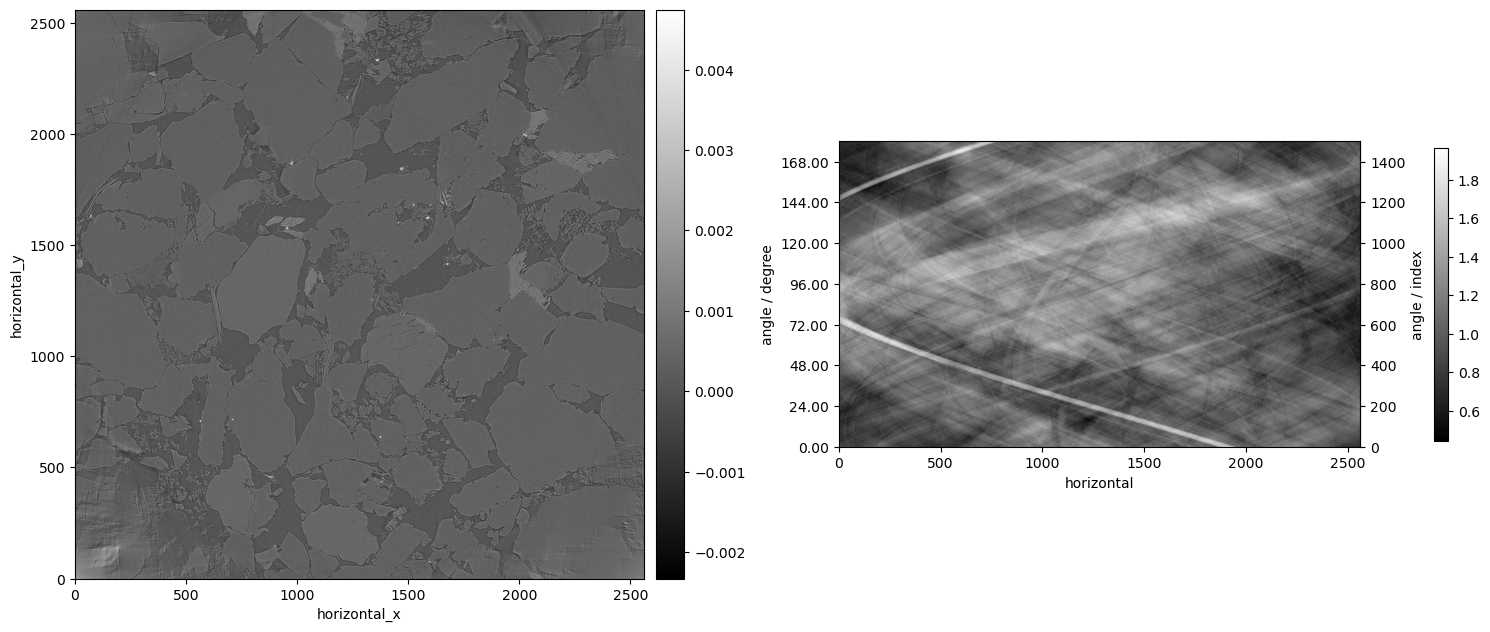

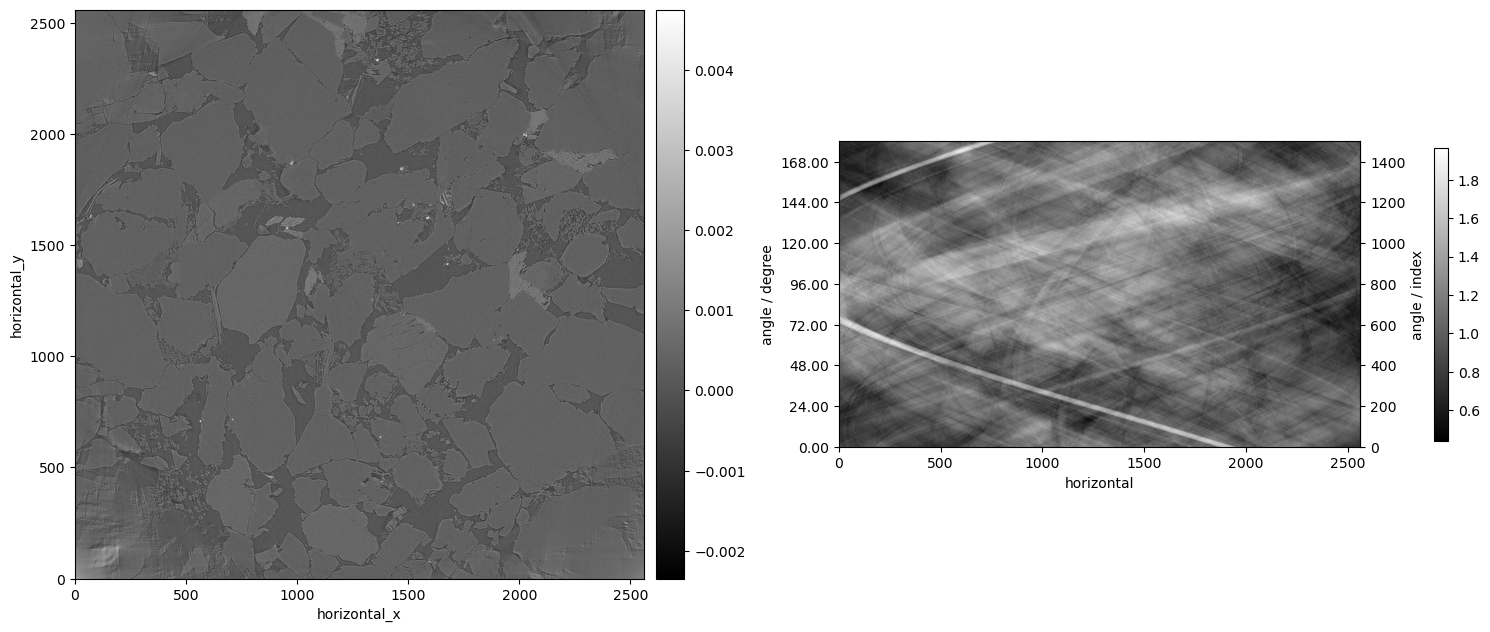

In [26]:
cgls_simple = CGLS(initial=initial, operator=A, data=sandstone_noisy)
times_cgls, rel_res_vec_cgls, rel_err_vec_cgls = timed_iterations(cgls_simple, N, itsAtATime)

lsqr_simple = LSQR(initial=initial, operator=A, data=sandstone_noisy)
times_lsqr, rel_res_vec_lsqr, rel_err_vec_lsqr = timed_iterations(lsqr_simple, N, itsAtATime)

#### Convergence/reduction of residuals:

The plots below show the progress of the residuals across each iteration, and the error across iterations:

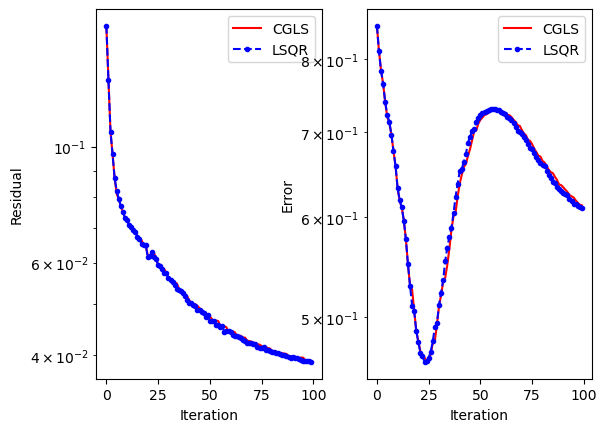

In [29]:
plt.subplot(1,2,1)
plt.semilogy(xx, rel_res_vec_cgls, 'r-', xx, rel_res_vec_lsqr, 'b.--')
plt.xlabel('Iteration') 
plt.ylabel('Residual') 
plt.gca().legend(('CGLS','LSQR'))

plt.subplot(1,2,2)
plt.semilogy(xx, rel_err_vec_cgls, 'r-', xx, rel_err_vec_lsqr, 'b.--')
plt.xlabel('Iteration') 
plt.ylabel('Error') 
plt.gca().legend(('CGLS','LSQR'))

We can also compare the time taken/elapsed across each iteration.  
For both algorithms, this relationship is linear. The time elapsed for the 100 iterations is faster for CGLS and LSQR.

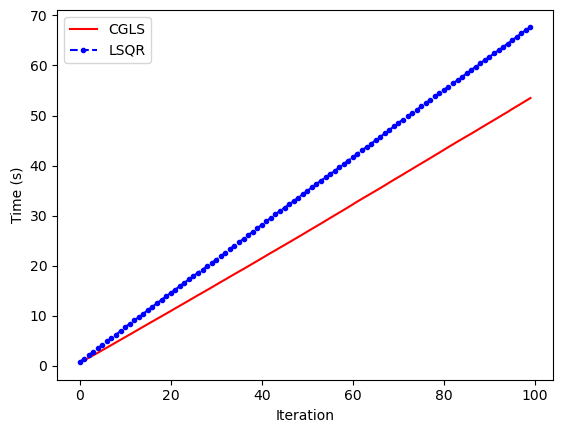

In [30]:
plt.plot(xx, times_cgls, 'r-', xx, times_lsqr, 'b.--')
plt.xlabel('Iteration') 
plt.ylabel('Time (s)')
plt.gca().legend(('CGLS','LSQR'))

### Memory Profiling

To profile the memory usage, a custom version of the CGLS file was created.
`CGLS_MP` uses the `memory_profiler` module to profile the `__init__, set_up and run` methods.  
To validate these results, `CGLS_LP` uses `psutil` to manually track the memory usage after each line in these methods. This version also tracks the memory usage in a separate thread, which shows the peak usages in each method. The same was done for LSQR.

Below, we will run the `memory-sandstone.py` script using the modified files, and analyse the outputs:

#### Validating Profiling Tools:

In [4]:
%%capture cgls_mem_prof
!python3 memory-sandstone.py cgls_mp

In [12]:
%%capture cgls_line_prof
!python3 memory-sandstone.py cgls_lp --track-peak

First, we can view the line-by-line memory increases from the `memory_profiler` output:

In [5]:
print(cgls_mem_prof)

Title: Synchrotron X-ray tomography data of sandstone (sample BBii)
Keywords: 
Publication date: 2021-06-08
DOI: 10.5281/zenodo.4912435
Total size: 207.3 MB

Link: https://zenodo.org/records/4912435/files/small.zip   size: 207.3 MB
100% [..................................................] 207330794 / 207330794
Checksum is correct. (1037af92cdbb0a831fa5609e2696f971)
All files have been downloaded.
Filename: /home/efv97572/forks/CIL-User-Showcase/016_Memory_Profiling_LSQR_CGLS/CGLSMP.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    81   655.63 MiB   655.63 MiB           1       @profile(precision=2)
    82                                             def set_up(self, initial, operator, data):
    83                                                 r'''Initialisation of the algorithm
    84                                                 Parameters
    85                                                 ------------
    86                                                 

In the `set_up` method, we can see: 
* 3 increases of **~53.9 MB** - these correspond to the size of the **ImageData** space
* 2 increases of **~21.5 MB** - corresponding to the **AcquisitionData** space

These increases are expected. In the `__init__` method, the same increase is seen as a result of the call to `set_up`.
In each run, there is an increase in memory usage due to the iterable, which calls the `update` method.

For easier visualisation of the Initial and Final usages per method, we process this output and display it as a dataframe:


In [6]:
cgls_mp = mem_prof_process(cgls_mem_prof)
cgls_mp

Method                                        Method Call  \
0   __init__  def __init__(self, initial=None, operator=None...   
1     set_up         def set_up(self, initial, operator, data):   
2      run 1  def run(self, iterations=None, callbacks: Opti...   
3      run 2  def run(self, iterations=None, callbacks: Opti...   
4      run 3  def run(self, iterations=None, callbacks: Opti...   
5      run 4  def run(self, iterations=None, callbacks: Opti...   
6      run 5  def run(self, iterations=None, callbacks: Opti...   
7      run 6  def run(self, iterations=None, callbacks: Opti...   
8      run 7  def run(self, iterations=None, callbacks: Opti...   
9      run 8  def run(self, iterations=None, callbacks: Opti...   
10     run 9  def run(self, iterations=None, callbacks: Opti...   
11    run 10  def run(self, iterations=None, callbacks: Opti...   

    Initial Memory Usage (MiB)  Final Memory Usage (MiB)  \
0                       655.62                    860.48   
1                       655.63                    860.48   
2                       860.48                    860.84   
3                       860.84                    860.96   
4                       860.96                    861.08   
5                       861.08                    861.12   
6                       861.12                    861.27   
7                       861.27                    861.32   
8                       861.32                    861.52   
9                       861.52                    861.37   
10                      861.37                    861.37   
11                      861.37                    861.37   

    Total Memory Usage (MiB)  
0                     204.86  
1                     204.85  
2                       0.36  
3                       0.12  
4                       0.12  
5                       0.04  
6                       0.15  
7                       0.05  
8                       0.20  
9                      -0.15  
10                      0.00  
11                      0.00

Let's compare these values to the line-by-line profiling results:

In [13]:
cgls_lp = line_prof_process(cgls_line_prof)
cgls_lp

Method  Initial Memory Usage (MiB)  Final Memory Usage (MiB)  \
0     init                      653.67                    858.52   
1    setup                      653.69                    858.52   
2    run 1                      858.57                    858.88   
3    run 2                      858.88                    859.18   
4    run 3                      859.18                    859.31   
5    run 4                      859.31                    859.36   
6    run 5                      859.36                    859.55   
7    run 6                      859.55                    859.59   
8    run 7                      859.59                    859.78   
9    run 8                      859.78                    859.86   
10   run 9                      859.86                    859.86   
11  run 10                      859.86                    859.87   

    Total Memory Usage (MiB)  
0                     204.85  
1                     204.83  
2                       0.31  
3                       0.30  
4                       0.13  
5                       0.05  
6                       0.19  
7                       0.04  
8                       0.19  
9                       0.08  
10                      0.00  
11                      0.01

As we can see, the major change in memory corresponding to `set_up` and `__init__` are the same, with minor variations in the memory usages of the `run` calls.

#### Peak Memory Usages:
We have validated the memory usage tracking using two techniques. For the remainder of the notebook, we will be using the line-by-line profiling technique for simplicity.

With this technique, we can also take a look at the peak memory usages that were measured on a separate thread, and the corresponding calls:

In [14]:
cgls_lp = line_peak_process(cgls_line_prof)
cgls_lp

Method  Initial Memory Usage (MiB)  Peak Memory  \
0        init                      653.67       858.52   
1       setup                      653.69       858.52   
2       run 1                      858.57       912.68   
3    update 1                      858.74       912.68   
4       run 2                      858.88       913.00   
5    update 2                      858.88       913.00   
6       run 3                      859.18       913.12   
7    update 3                      859.18       913.12   
8       run 4                      859.31       913.25   
9    update 4                      859.31       913.25   
10      run 5                      859.36       913.37   
11   update 5                      859.36       913.37   
12      run 6                      859.55       913.48   
13   update 6                      859.55       913.48   
14      run 7                      859.59       913.60   
15   update 7                      859.59       913.60   
16      run 8                      859.78       913.73   
17   update 8                      859.78       913.73   
18      run 9                      859.86       913.79   
19   update 9                      859.86       913.79   
20     run 10                      859.86       913.79   
21  update 10                      859.86       913.79   

    Final Memory Usage (MiB)  Total Memory Usage (MiB)  \
0                     858.52                    204.85   
1                     858.52                    204.83   
2                     858.88                      0.31   
3                     858.88                      0.14   
4                     859.18                      0.30   
5                     858.95                      0.07   
6                     859.31                      0.13   
7                     859.31                      0.13   
8                     859.36                      0.05   
9                     859.36                      0.05   
10                    859.55                      0.19   
11                    859.52                      0.16   
12                    859.59                      0.04   
13                    859.59                      0.04   
14                    859.78                      0.19   
15                    859.71                      0.12   
16                    859.86                      0.08   
17                    859.86                      0.08   
18                    859.86                      0.00   
19                    859.78                     -0.08   
20                    859.87                      0.01   
21                    859.87                      0.01   

    Peak Memory Increase (MiB)  \
0                       204.85   
1                       204.83   
2                        54.11   
3                        53.94   
4                        54.12   
5                        54.12   
6                        53.94   
7                        53.94   
8                        53.94   
9                        53.94   
10                       54.01   
11                       54.01   
12                       53.93   
13                       53.93   
14                       54.01   
15                       54.01   
16                       53.95   
17                       53.95   
18                       53.93   
19                       53.93   
20                       53.93   
21                       53.93   

                                            Peak Line  
0   self.set_up(initial=initial, operator=operator...  
1   self.q = self.operator.range_geometry().alloca...  
2                                        update(self)  
3            self.operator.direct(self.p, out=self.q)  
4                                        update(self)  
5            self.operator.direct(self.p, out=self.q)  
6                                        update(self)  
7            self.operator.direct(self.p, out=self.q)  
8                                        update(se

This table shows that CGLS' `set_up` and `__init__` calls do not have a spike in memory that exceeds the final usage. However, during the runs, the `update(self)` call produces peak increases around the size of the ImageData space. This memory usage is transient, and is released by the time the call is finished.

Looking at the **Method**=`update` Peak lines, we can see the biggest peak is attributed to the line `self.operator.direct(self.p, out=self.q)`, which creates a copy of the ImageData space during its execution.

Below, we visualise this by plotting the total memory increases and the peak memory increases as bar plots:

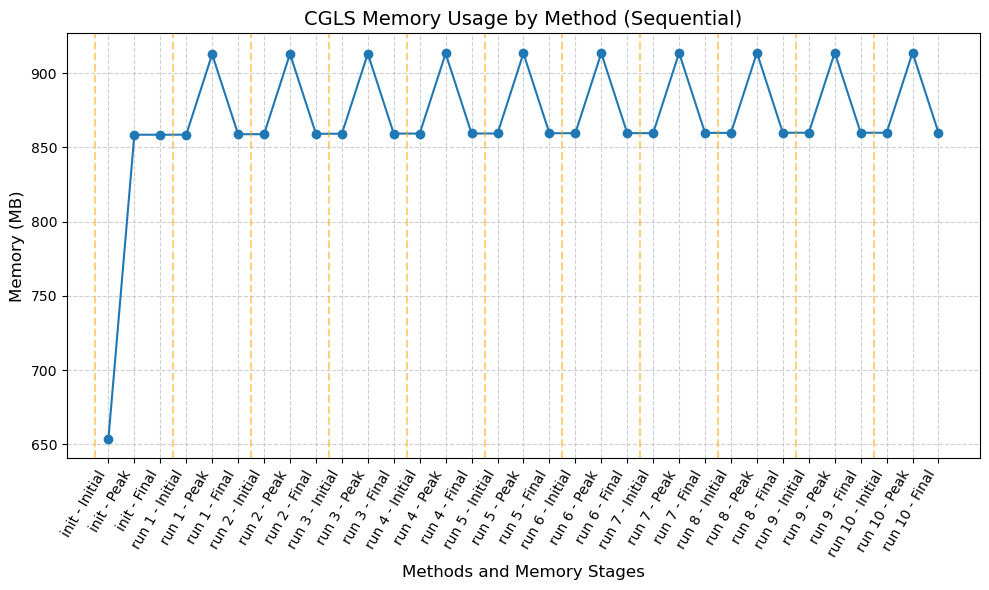

In [15]:
plot_mem(cgls_lp, algNm="CGLS")

#### Comparison With LSQR:
Let's compare this to LSQR's memory usage:

In [7]:
%%capture lsqr_line_prof
!python3 memory-sandstone.py lsqr_lp --track-peak

In [8]:
lsqr_lp = line_peak_process(lsqr_line_prof)
lsqr_lp

Method  Initial Memory Usage (MiB)  Peak Memory  \
0        init                      653.53       836.73   
1       setup                      653.55       836.73   
2       run 1                      836.88       983.04   
3    update 1                      836.99       983.04   
4       run 2                      837.29       981.11   
5    update 2                      837.29       981.11   
6       run 3                      837.42       983.08   
7    update 3                      837.42       983.08   
8       run 4                      837.50       983.32   
9    update 4                      837.50       983.32   
10      run 5                      837.59       981.30   
11   update 5                      837.59       981.30   
12      run 6                      837.67       979.50   
13   update 6                      837.67       979.50   
14      run 7                      837.74       981.55   
15   update 7                      837.74       981.55   
16      run 8                      837.81       981.68   
17   update 8                      837.81       981.68   
18      run 9                      837.88       979.68   
19   update 9                      837.88       979.68   
20     run 10                      837.95       993.82   
21  update 10                      837.95       993.82   

    Final Memory Usage (MiB)  Total Memory Usage (MiB)  \
0                     836.73                    183.20   
1                     836.73                    183.18   
2                     837.29                      0.41   
3                     837.29                      0.30   
4                     837.42                      0.13   
5                     837.42                      0.13   
6                     837.50                      0.08   
7                     837.50                      0.08   
8                     837.59                      0.09   
9                     837.59                      0.09   
10                    837.67                      0.08   
11                    837.67                      0.08   
12                    837.74                      0.07   
13                    837.74                      0.07   
14                    837.81                      0.07   
15                    837.81                      0.07   
16                    837.88                      0.07   
17                    837.88                      0.07   
18                    837.95                      0.07   
19                    837.95                      0.07   
20                    838.02                      0.07   
21                    838.02                      0.07   

    Peak Memory Increase (MiB)  \
0                       183.20   
1                       183.18   
2                       146.16   
3                       146.05   
4                       143.82   
5                       143.82   
6                       145.66   
7                       145.66   
8                       145.82   
9                       145.82   
10                      143.71   
11                      143.71   
12                      141.83   
13                      141.83   
14                      143.81   
15                      143.81   
16                      143.87   
17                      143.87   
18                      141.80   
19                      141.80   
20                      155.87   
21                      155.87   

                                            Peak Line  
0   self.set_up(initial=initial, operator=operator...  
1     self.d = operator.domain_geometry().allocate(0)  
2                                        update(self)  
3   self.v = self.operator.adjoint(self.u) - self....  
4                                        update(self)  
5   self.v = self.operator.adjoint(self.u) - self....  
6                                        update(self)  
7   self.v = self.operator.adjoint(self.u) - self....  
8                                        update(se

The table and plots show that LSQR has a **lower setup cost than CGLS**, as it has:
* 3 increases of **~53.9 MB** - corresponding to the size of the **ImageData** space
* 1 increase of **~21.5 MB** - corresponding to the **AcquisitionData** space

In the `run` calls, there is much greater peak in memory usage due to the `update` method. The largest spike is due to the line `self.v = self.operator.adjoint(self.u) - self.beta * self.v`. 

By analysing the raw line-by-line output, we can get more information on the lines contributing to large memory spikes. From the output below, `self.u = self.operator.direct(self.v) - self.alpha * self.u` which creates a spike of 53.79 MB, as it creates a copy of the ImageData space.

In [9]:
# Uncomment to view full line-by-line & peak usage output:
print(lsqr_line_prof)

Tracking Peak Usage
Dataset folder already exists in .
Start of init | Memory Usage: 653.53 MB | line:  
1 | Memory Usage: 653.55 MB | line:  
2 | Memory Usage: 653.55 MB | line:  

Memory Usage Log (Time, Memory in MB): 16:56:38.658898, 653.55 MB
Start of setup | Memory Usage: 653.55 MB | line:  

Memory Usage Log (Time, Memory in MB): 16:56:38.669266, 675.44 MB

Memory Usage Log (Time, Memory in MB): 16:56:38.679512, 699.44 MB
3 | Memory Usage: 707.44 MB | line: self.x = initial.copy()
4 | Memory Usage: 707.44 MB | line: self.operator = operator

Memory Usage Log (Time, Memory in MB): 16:56:38.741100, 761.39 MB

Memory Usage Log (Time, Memory in MB): 16:56:38.751352, 761.42 MB

Memory Usage Log (Time, Memory in MB): 16:56:38.761538, 761.42 MB

Memory Usage Log (Time, Memory in MB): 16:56:38.771728, 761.42 MB

Memory Usage Log (Time, Memory in MB): 16:56:38.782019, 761.42 MB

Memory Usage Log (Time, Memory in MB): 16:56:38.792248, 761.42 MB

Memory Usage Log (Time, Memory in MB): 16:5

Below is a graph illustrating the overall trends across the methods, showing the comparison for CGLS and LSQR:

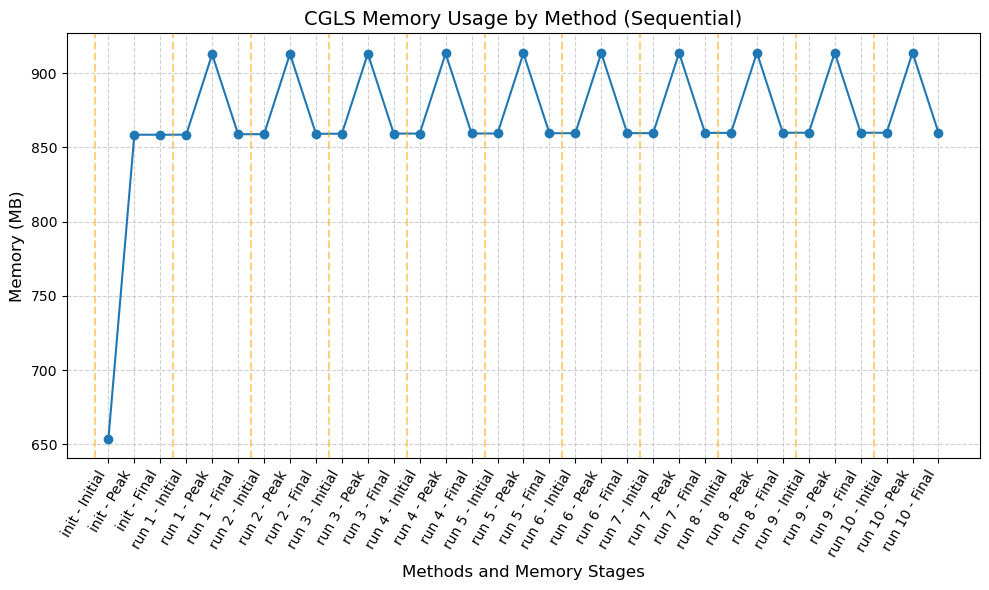

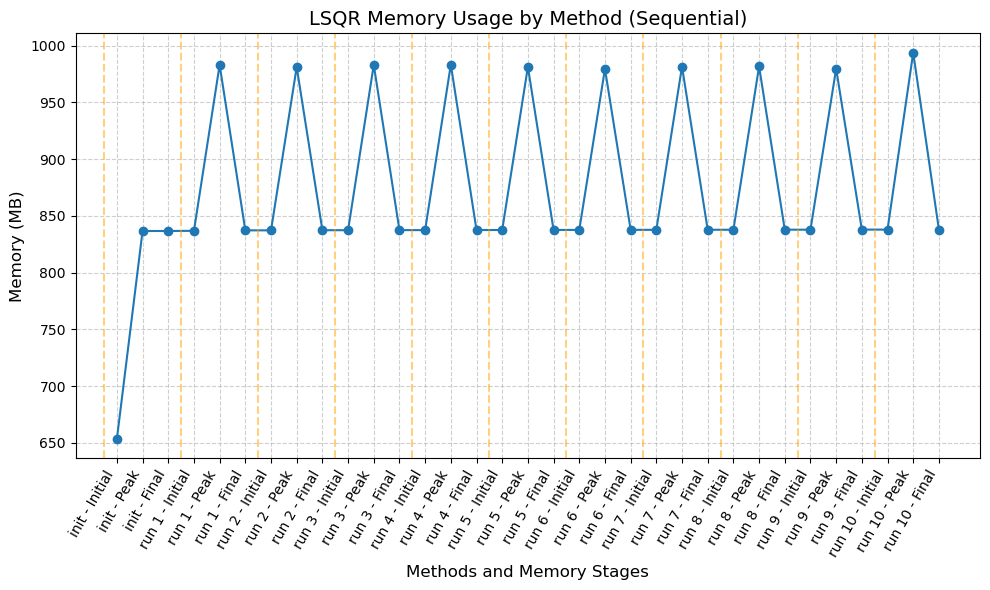

In [16]:
plot_mem(cgls_lp, algNm="CGLS")
plot_mem(lsqr_lp, algNm="LSQR")

LSQR creates 3 copies of the ImageData space, but only 1 copy of the AcquisitionData, totalling to **~183.2 MB**. This can be seen clearly in the breakdown below:

In [11]:
# Uncomment to see memory_profiler breakdown:
!python3 memory-sandstone.py lsqr_mp

Dataset folder already exists in .
Filename: /home/efv97572/forks/CIL-User-Showcase/016_Memory_Profiling_LSQR_CGLS/LSQRMP.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    80    653.7 MiB    653.7 MiB           1       @profile
    81                                             def set_up(self, initial, operator, data):
    82                                                 r'''Initialisation of the algorithm
    83                                                 Parameters
    84                                                 ------------
    85                                                 operator : Operator
    86                                                     Linear operator for the inverse problem
    87                                                 initial : (optional) DataContainer in the domain of the operator, default is a DataContainer filled with zeros. 
    88                                                     Initial guess 
    89           

### Tikhonov regularisation using CGLS and LSQR - with or without a block

#### Tikhonov regularisation

We can add a regularisation term to problem solved by CGLS; this gives us the minimisation problem in the following form, which is known as Tikhonov regularisation:
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b \end{Vmatrix}^2_2 + \alpha^2\|u\|^2_2$$

where,

- $A$ is the projection operator

- $b$ is the acquired data

- $u$ is the unknown image to be solved for

- $\alpha$ is the regularisation parameter


The first term measures the fidelity of the solution to the data. The second term meausures the fidelity to the prior knowledge we have imposed on the system, operator $L$. $\alpha$ controls the trade-off between these terms. $L$ is often chosen to be a smoothing operator like the identity matrix, or a gradient operator **constrained to the squared L2-norm**.

This can be re-written equivalently in the block matrix form:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\binom{A}{\alpha I} u - \binom{b}{0}\end{Vmatrix}^2_2$$

With the definitions:

- $\tilde{A} = \binom{A}{\alpha I}$

- $\tilde{b} = \binom{b}{0}$

this can now be recognised as a least squares problem:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\tilde{A} u - \tilde{b}\end{Vmatrix}^2_2$$

and being a least squares problem, it can be solved using CGLS with $\tilde{A}$ as operator and $\tilde{b}$ as data.


Set up the algorithms:

In [43]:
initial = ig.allocate(0)

L = IdentityOperator(ig)
alpha = 0.1

operator_block = BlockOperator(A, alpha*L)
zero_data = L.range.allocate(0)
data_block = BlockDataContainer(sandstone_noisy, zero_data)

sino_norm = Slicer(roi)(sandstone_cor).norm() # crop the 'perfect' sinogram
recon_norm = recon.norm() # 'perfect' reconstruction, already cropped

maxit = 100
itsAtATime = 1
N = round(maxit/itsAtATime)

xx = np.arange(0, maxit, itsAtATime)

In [ ]:
cgls_tik_block = CGLS(initial=initial, operator=operator_block, data=data_block, update_objective_interval = 10)
times_cgls_tik_block, rel_res_vec_cgls_tik_block, rel_err_vec_cgls_tik_block = timed_iterations(cgls_tik_block, N, itsAtATime)

lsqr_tik_block = LSQR(initial=initial, operator=operator_block, data=data_block, update_objective_interval = 10)
times_lsqr_tik_block, rel_res_vec_lsqr_tik_block, rel_err_vec_lsqr_tik_block = timed_iterations(lsqr_tik_block, N, itsAtATime)

lsqr_tik_simple = LSQR_Tikhonov(initial=initial, operator=A, data=sandstone_noisy, alpha = alpha)
times_lsqr_tik_simple, rel_res_vec_lsqr_tik_simple, rel_err_vec_lsqr_tik_simple = timed_iterations(lsqr_tik_simple, N, itsAtATime)

#### Convergence/reduction of residuals:

The plots below show the progress of the residuals across each iteration, and the error across iterations:

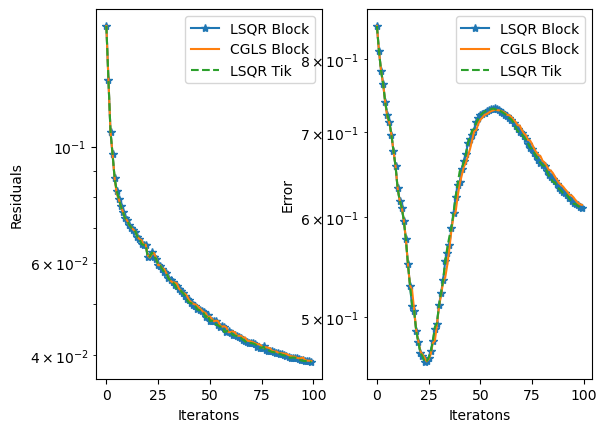

In [47]:
plt.subplot(1,2,1)
plt.semilogy(xx, rel_res_vec_lsqr_tik_block, '*-', xx, rel_res_vec_cgls_tik_block, '-', xx, rel_res_vec_lsqr_tik_simple, '--')
plt.xlabel('Iteratons') 
plt.ylabel('Residuals') 
plt.gca().legend(('LSQR Block', 'CGLS Block', 'LSQR Tik'))

plt.subplot(1,2,2)
plt.semilogy(xx, rel_err_vec_lsqr_tik_block, '*-', xx, rel_err_vec_cgls_tik_block, '-', xx, rel_err_vec_lsqr_tik_simple, '--')
plt.xlabel('Iteratons') 
plt.ylabel('Error') 
plt.gca().legend(('LSQR Block', 'CGLS Block', 'LSQR Tik'))

Comparing the time taken/elapsed across each iteration shows that LSQR Tik and CGLS Block are slightly faster in comparison to LSQR Block for 100 iterations, with CGLS Block being the fastest overall.

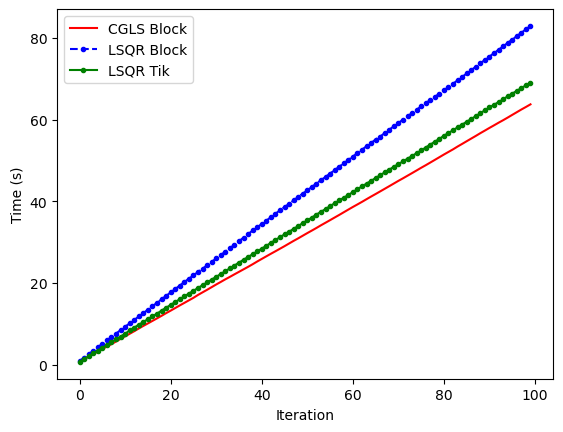

In [51]:
plt.plot(xx, times_cgls_tik_block, 'r-', xx, times_lsqr_tik_block, 'b.--', xx, times_lsqr_tik_simple, 'g.-' )
plt.xlabel('Iteration') 
plt.ylabel('Time (s)')
plt.gca().legend(('CGLS Block', 'LSQR Block', 'LSQR Tik'))

### Memory costs for LSQR+Block, CGLS+Block and LSQR+Tikhonov

Setup the memory tracking for the three algorithms:

In [72]:
%%capture cgls_block_prof
!python3 memory-sandstone.py cgls_lp_tik_block --track-peak

In [73]:
%%capture lsqr_block_prof
!python3 memory-sandstone.py lsqr_lp_tik_block --track-peak

In [86]:
%%capture lsqr_tik_prof
!python3 memory-sandstone.py lsqr_tik_lp --track-peak

In the setup for CGLS Block, the ImageData space is 53.9 MB but the AcquisitionData is now 75.6 MB.  
Since the algorithm is the same, we expect the same number of increases as before. In total, we expect a setup increase of:
(53.9 * 3) + (75.6 * 2) = **~312.9 MB**

Which is what is reflected in the CGLS Block DataFrame below:

In [79]:
cgls_block_lp = line_peak_process(cgls_block_prof)
cgls_block_lp.iloc[:12] # Truncate no. of rows

Method  Initial Memory Usage (MiB)  Peak Memory  \
0       init                      708.46      1021.20   
1      setup                      708.46      1021.20   
2      run 1                     1021.20      1150.71   
3   update 1                     1021.32      1150.71   
4      run 2                     1043.12      1151.12   
5   update 2                     1043.12      1151.12   
6      run 3                     1043.31      1151.26   
7   update 3                     1043.31      1151.26   
8      run 4                     1043.46      1151.41   
9   update 4                     1043.46      1151.41   
10     run 5                     1043.61      1151.56   
11  update 5                     1043.61      1151.56   

    Final Memory Usage (MiB)  Total Memory Usage (MiB)  \
0                    1021.20                    312.74   
1                    1021.20                    312.74   
2                    1043.12                     21.92   
3                    1043.12                     21.80   
4                    1043.31                      0.19   
5                    1043.31                      0.19   
6                    1043.46                      0.15   
7                    1043.46                      0.15   
8                    1043.61                      0.15   
9                    1043.61                      0.15   
10                   1043.84                      0.23   
11                   1043.84                      0.23   

    Peak Memory Increase (MiB)  \
0                       312.74   
1                       312.74   
2                       129.51   
3                       129.39   
4                       108.00   
5                       108.00   
6                       107.95   
7                       107.95   
8                       107.95   
9                       107.95   
10                      107.95   
11                      107.95   

                                            Peak Line  
0   self.set_up(initial=initial, operator=operator...  
1                         self.norms0 = self.s.norm()  
2                                        update(self)  
3            self.operator.direct(self.p, out=self.q)  
4                                        update(self)  
5            self.operator.direct(self.p, out=self.q)  
6                                        update(self)  
7            self.operator.direct(self.p, out=self.q)  
8                                        update(self)  
9            self.operator.direct(self.p, out=self.q)  
10                                       update(self)  
11           self.operator.direct(self.p, out=self.q)

We expect the same with LSQR block, in this case, 3 copies of ImageData and one copy of AcquisitionData:  
(53.9 * 3) + (75.6) = **~237.3 MB Total Memory Usage** (init/setup)

In [80]:
lsqr_block_lp = line_peak_process(lsqr_block_prof)
lsqr_block_lp.iloc[:12] # Truncate no. of rows

Method  Initial Memory Usage (MiB)  Peak Memory  \
0       init                      707.61       944.92   
1      setup                      707.61       944.92   
2      run 1                      944.92      1145.76   
3   update 1                      945.04      1145.76   
4      run 2                      945.34      1130.11   
5   update 2                      945.34      1130.11   
6      run 3                      945.42      1133.98   
7   update 3                      945.42      1133.98   
8      run 4                      945.51      1132.34   
9   update 4                      945.51      1132.34   
10     run 5                      945.59      1132.41   
11  update 5                      945.59      1132.41   

    Final Memory Usage (MiB)  Total Memory Usage (MiB)  \
0                     944.92                    237.31   
1                     944.92                    237.31   
2                     945.34                      0.42   
3                     945.34                      0.30   
4                     945.42                      0.08   
5                     945.42                      0.08   
6                     945.51                      0.09   
7                     945.51                      0.09   
8                     945.59                      0.08   
9                     945.59                      0.08   
10                    945.67                      0.08   
11                    945.67                      0.08   

    Peak Memory Increase (MiB)  \
0                       237.31   
1                       237.31   
2                       200.84   
3                       200.72   
4                       184.77   
5                       184.77   
6                       188.56   
7                       188.56   
8                       186.83   
9                       186.83   
10                      186.82   
11                      186.82   

                                            Peak Line  
0   self.set_up(initial=initial, operator=operator...  
1     self.d = operator.domain_geometry().allocate(0)  
2                                        update(self)  
3   self.u = self.operator.direct(self.v) - self.a...  
4                                        update(self)  
5   self.u = self.operator.direct(self.v) - self.a...  
6                                        update(self)  
7   self.u = self.operator.direct(self.v) - self.a...  
8                                        update(self)  
9   self.u = self.operator.direct(self.v) - self.a...  
10                                       update(self)  
11  self.u = self.operator.direct(self.v) - self.a...

The setup for LSQR Tikhonov does not use the Block operator, so the ImageData and AcquisitionData sizes are **53.9 MB** and **21.5 MB**, respectively.

We can see that the Total Memory Usage corresponds to:
* 2 copies of ImageData
* 1 copy of AcquisitionData

Totalling to a usage of: (53.9 * 2) + 21.5 = **~129.3 MB**, showing LSQR Tikhonov will use much less memory to setup than CGLS and LSQR.

Notably, LSQR Tikhonov shows an increase of ~54 MB at the first iteration only. Looking at the line-by-line output, it appears that this increase is a result of some deallocations, and then an increase of ~75 MB from the line `self.v = self.operator.adjoint(self.u) - self.beta * self.v`. The deallocations and the increase result in a net increase of ~54 MB. The memory after this line then plateaus until the end of `run`.

In contrast, in subsequent iterations this line produces an increase of only ~21.4 MB, which in conjunction with the deallocations, results in a net increase of <0.18 MB.

In [87]:
print(lsqr_tik_prof)

Tracking Peak Usage
Dataset folder already exists in .
Start of init | Memory Usage: 653.71 MB | line:  

Memory Usage Log (Time, Memory in MB): 16:15:04.803069, 653.71 MB
1 | Memory Usage: 653.71 MB | line:  
2 | Memory Usage: 653.71 MB | line:  
Start of setup | Memory Usage: 653.71 MB | line:  

Memory Usage Log (Time, Memory in MB): 16:15:04.813504, 675.61 MB

Memory Usage Log (Time, Memory in MB): 16:15:04.823750, 697.61 MB
3 | Memory Usage: 707.61 MB | line: self.x = initial.copy()
4 | Memory Usage: 707.61 MB | line: self.operator = operator

Memory Usage Log (Time, Memory in MB): 16:15:04.884137, 761.34 MB

Memory Usage Log (Time, Memory in MB): 16:15:04.894389, 761.58 MB

Memory Usage Log (Time, Memory in MB): 16:15:04.904676, 761.58 MB

Memory Usage Log (Time, Memory in MB): 16:15:04.914971, 761.58 MB

Memory Usage Log (Time, Memory in MB): 16:15:04.925194, 761.58 MB

Memory Usage Log (Time, Memory in MB): 16:15:04.935417, 761.58 MB

Memory Usage Log (Time, Memory in MB): 16:1

In [ ]:
lsqr_tik_lp = line_peak_process(lsqr_tik_prof)
lsqr_tik_lp.iloc[:12] # Truncate no. of rows

Method  Initial Memory Usage (MiB)  Peak Memory  \
0       init                      653.71       822.95   
1      setup                      653.71       822.95   
2      run 1                      783.14       934.95   
3   update 1                      783.26       934.95   
4      run 2                      837.34       983.19   
5   update 2                      837.34       983.19   
6      run 3                      837.41       987.29   
7   update 3                      837.41       987.29   
8      run 4                      837.57       991.40   
9   update 4                      837.66       991.40   
10     run 5                      837.75       991.44   
11  update 5                      837.75       991.44   

    Final Memory Usage (MiB)  Total Memory Usage (MiB)  \
0                     783.14                    129.43   
1                     783.14                    129.43   
2                     837.34                     54.20   
3                     837.34                     54.08   
4                     837.41                      0.07   
5                     837.43                      0.09   
6                     837.57                      0.16   
7                     837.57                      0.16   
8                     837.75                      0.18   
9                     837.59                     -0.07   
10                    837.68                     -0.07   
11                    837.68                     -0.07   

    Peak Memory Increase (MiB)  \
0                       169.24   
1                       169.24   
2                       151.81   
3                       151.69   
4                       145.85   
5                       145.85   
6                       149.88   
7                       149.88   
8                       153.83   
9                       153.74   
10                      153.69   
11                      153.69   

                                            Peak Line  
0   self.set_up(initial=initial, operator=operator...  
1                          self.v = self.v/self.alpha  
2                                        update(self)  
3   self.v = self.operator.adjoint(self.u) - self....  
4                                        update(self)  
5   self.v = self.operator.adjoint(self.u) - self....  
6                                        update(self)  
7   self.v = self.operator.adjoint(self.u) - self....  
8                                        update(self)  
9   self.v = self.operator.adjoint(self.u) - self....  
10                                       update(self)  
11  self.v = self.operator.adjoint(self.u) - self....

The graphs below show the memory usage trends across the method calls. Despite the increase in the first iteration of LSQR Tikhonov, it has the lowest setup and peak memory usages of the algorithms.

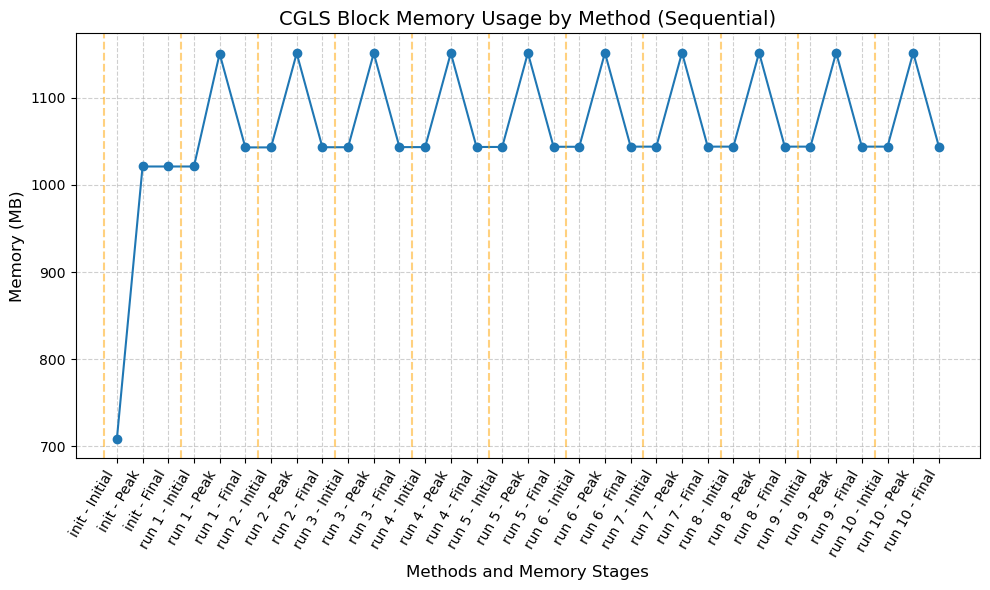

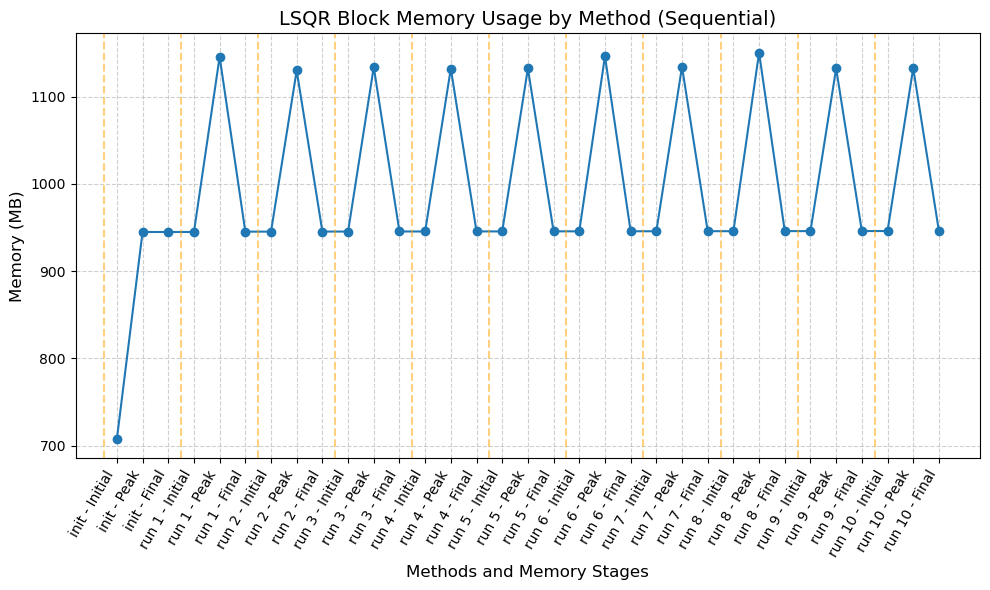

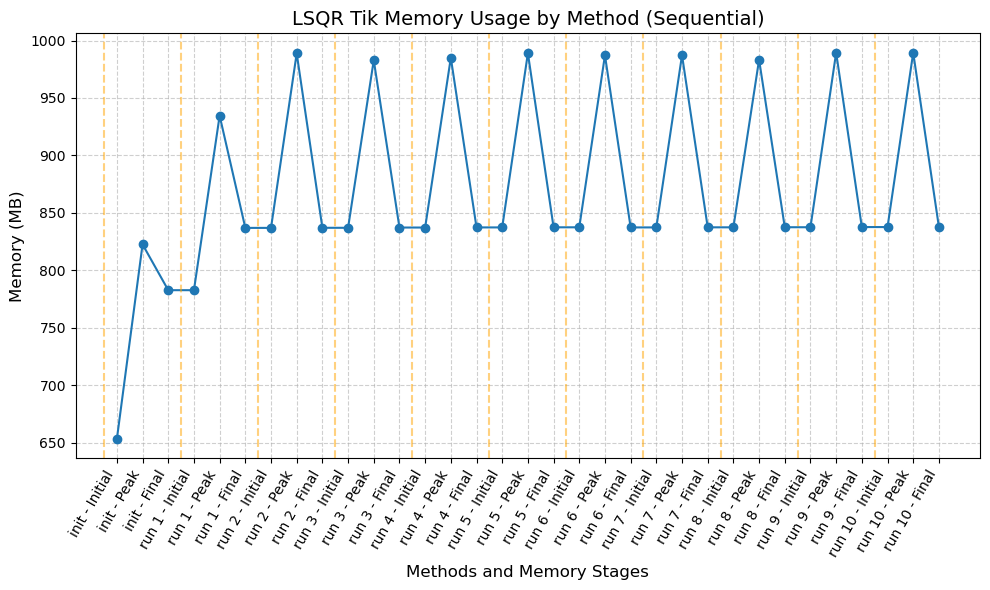

In [84]:
plot_mem(cgls_block_lp, algNm="CGLS Block")
plot_mem(lsqr_block_lp, algNm="LSQR Block")
plot_mem(lsqr_tik_lp, algNm="LSQR Tik")

### Comparisons of average iteration times and peak memory usage (Unsure if keeping)

In [90]:
# Average time per iteration
avg_time_simple = [np.mean(np.diff(times_cgls, prepend=0)), np.mean(np.diff(times_lsqr, prepend=0))]

avg_time_tik = [np.mean(np.diff(times_cgls_tik_block, prepend=0)), np.mean(np.diff(times_lsqr_tik_block, prepend=0)), np.mean(np.diff(times_lsqr_tik_simple, prepend=0))]

In [91]:
# Average total memory usage per iteration
avg_mem_simple = [np.mean(mem_cgls[0]), np.mean(mem_lsqr[0])]

avg_mem_tik = [np.mean(mem_cgls_tik_block[0]), np.mean(mem_lsqr_tik_block[0]), np.mean(mem_lsqr_tik_simple[0])]

# Average peak memory usage per iteration
pavg_mem_simple = [np.mean(mem_cgls[1]), np.mean(mem_lsqr[1])]
                           
pavg_mem_tik = [np.mean(mem_cgls_tik_block[1]), np.mean(mem_lsqr_tik_block[1]), np.mean(mem_lsqr_tik_simple[1])]

The bar graphs below show the average time per iteration:

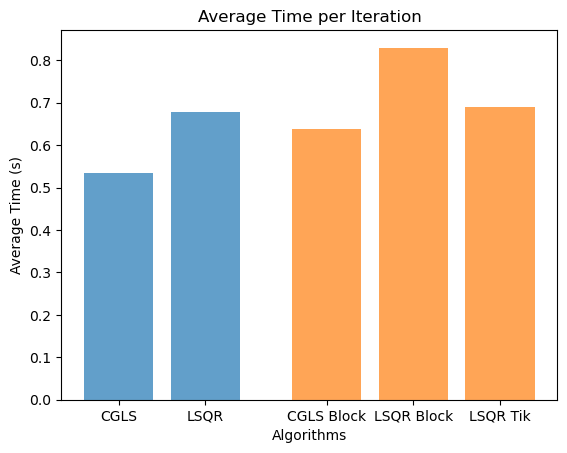

In [92]:
group1_x = np.arange(len(avg_time_simple))  # Positions
group2_x = np.arange(len(avg_time_tik)) + len(avg_time_simple) + 0.4 # Positions with a gap

# Plot bars
plt.bar(group1_x, avg_time_simple, alpha=0.7)
plt.bar(group2_x, avg_time_tik, alpha=0.7)

# Set x-ticks and labels
xticks_positions = np.concatenate([group1_x, group2_x])
xticks_labels = ['CGLS', 'LSQR'] + ['CGLS Block', 'LSQR Block', 'LSQR Tik']

plt.xticks(xticks_positions, xticks_labels)
plt.xlabel("Algorithms")
plt.ylabel("Average Time (s)")
plt.title("Average Time per Iteration")
plt.show()

Average peak memory usage per iteration and average total memory usage per iteration:

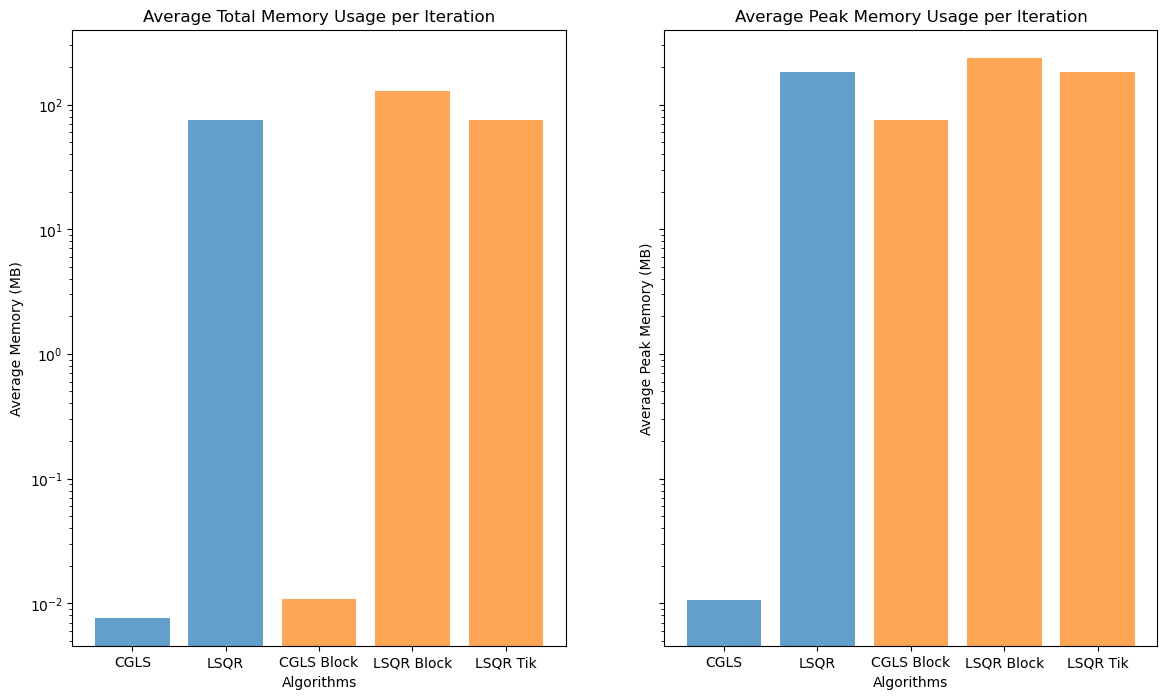

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

group1_x = np.arange(len(avg_mem_simple))  # Positions
group2_x = np.arange(len(avg_mem_tik)) + len(avg_mem_simple) # Positions with a gap

# Plot bars for first graph
axes[0].bar(group1_x, avg_mem_simple, alpha=0.7)
axes[0].bar(group2_x, avg_mem_tik, alpha=0.7)

# Set x-ticks and labels
axes[0].set_xticks(np.concatenate([group1_x, group2_x]))
axes[0].set_xticklabels(['CGLS', 'LSQR'] + ['CGLS Block', 'LSQR Block', 'LSQR Tik'])
axes[0].set_title("Average Total Memory Usage per Iteration")
axes[0].set_xlabel("Algorithms")
axes[0].set_ylabel("Average Memory (MB)")
axes[0].set_yscale('log')


# Plot bars for second graph
axes[1].bar(group1_x, pavg_mem_simple, alpha=0.7)
axes[1].bar(group2_x, pavg_mem_tik, alpha=0.7)

# Set x-ticks and labels
axes[1].set_xticks(np.concatenate([group1_x, group2_x]))
axes[1].set_xticklabels(['CGLS', 'LSQR'] + ['CGLS Block', 'LSQR Block', 'LSQR Tik'])
axes[1].set_title("Average Peak Memory Usage per Iteration")
axes[1].set_xlabel("Algorithms")
axes[1].set_ylabel("Average Peak Memory (MB)")
axes[1].set_yscale('log')


plt.show()